<a href="https://colab.research.google.com/github/yes-wook/NLP_STRUGGLE/blob/main/%ED%95%9C%EA%B5%AD%EC%96%B4_%EA%B0%9C%EC%B1%84%EB%AA%85_%EC%9D%B8%EC%8B%9D(BERT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 한국어 개체명 인식기 실습

![BERT 모델](https://camo.githubusercontent.com/eea6dc07ad873471be054698e4e3da80aa43d409/68747470733a2f2f692e696d6775722e636f6d2f504464544c6a792e706e67)

![링크 텍스트](https://camo.githubusercontent.com/3438ac9a7093d7c42d48da32e0df774eb885079e/68747470733a2f2f692e696d6775722e636f6d2f697434755445332e706e67)

이번 실습은 

- 1) 네이버 개체명 인식 데이터 불러오기 및 전처리 
- 2) BERT 인풋 만들기 
- 3) 버트를 활용한 개체명 인식 모델 만들기 
- 4) 훈련 및 성능 검증 
- 5) 실제 데이터로 실습하기

로 구성되어 있습니다.

### 1)데이터 불러오기 및 전처리

In [2]:
!wget https://github.com/naver/nlp-challenge/raw/master/missions/ner/data/train/train_data

--2021-02-01 07:02:50--  https://github.com/naver/nlp-challenge/raw/master/missions/ner/data/train/train_data
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/naver/nlp-challenge/master/missions/ner/data/train/train_data [following]
--2021-02-01 07:02:50--  https://raw.githubusercontent.com/naver/nlp-challenge/master/missions/ner/data/train/train_data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16945023 (16M) [text/plain]
Saving to: ‘train_data’

train_data          100%[===================>]  16.16M  48.7MB/s    in 0.3s    

2021-02-01 07:02:51 (48.7 MB/s) - ‘train_data’ saved [16945023/16945023]

In [1]:
!pip install transformers
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
from tqdm import tqdm
import os
import re

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 1.8MB 6.7MB/s 
     |████████████████████████████████| 2.9MB 36.7MB/s 
     |████████████████████████████████| 890kB 38.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=d75c53c910828755341d9898539124dbc28dd1de1c26be8ea6f5256b6b1a4914
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Load Data 

In [3]:
train = pd.read_csv("train_data", names=['src', 'tar'], sep="\t")
train = train.reset_index()
train

,index,src,tar
0,1,비토리오,PER_B
1,2,양일,DAT_B
2,3,만에,-
3,4,영사관,ORG_B
4,5,감호,CVL_B
...,...,...,...
769060,2,어째,-
769061,3,뭔가,-
769062,4,수상쩍은,-
769063,5,좌담,-


### Preprocessing

In [4]:
## 마침표 확실하게 처리
train['src'] = train['src'].replace(". ",".", regex=False)

In [5]:
## 특수 문자 제거
train['src'] = train['src'].astype(str)
train['tar'] = train['tar'].astype(str)

train['src'] = train['src'].str.replace(r'[^ㄱ-ㅣ가-힣0-9a-zA-Z.]+', "", regex=True)

In [6]:
data = [list(x) for x in train[['index', 'src', 'tar']].to_numpy()]

In [7]:
data[:15]

[[1, '비토리오', 'PER_B'],
 [2, '양일', 'DAT_B'],
 [3, '만에', '-'],
 [4, '영사관', 'ORG_B'],
 [5, '감호', 'CVL_B'],
 [6, '용퇴', '-'],
 [7, '항룡', '-'],
 [8, '압력설', '-'],
 [9, '의심만', '-'],
 [10, '가율', '-'],
 [1, '이', '-'],
 [2, '음경동맥의', '-'],
 [3, '직경이', '-'],
 [4, '8', 'NUM_B'],
 [5, '19mm입니다', 'NUM_B']]

라벨들을 추출하고, 딕셔너리 형태로 저장

In [8]:
label = train['tar'].unique().tolist()
label_dict = {word:i for i,word in enumerate(label)}
label_dict.update({"[PAD]":len(label_dict)})
index_to_ner = {i:j for j,i in label_dict.items()}

In [9]:
print(label_dict)
print(index_to_ner)

{'PER_B': 0, 'DAT_B': 1, '-': 2, 'ORG_B': 3, 'CVL_B': 4, 'NUM_B': 5, 'LOC_B': 6, 'EVT_B': 7, 'TRM_B': 8, 'TRM_I': 9, 'EVT_I': 10, 'PER_I': 11, 'CVL_I': 12, 'NUM_I': 13, 'TIM_B': 14, 'TIM_I': 15, 'ORG_I': 16, 'DAT_I': 17, 'ANM_B': 18, 'MAT_B': 19, 'MAT_I': 20, 'AFW_B': 21, 'FLD_B': 22, 'LOC_I': 23, 'AFW_I': 24, 'PLT_B': 25, 'FLD_I': 26, 'ANM_I': 27, 'PLT_I': 28, '[PAD]': 29}
{0: 'PER_B', 1: 'DAT_B', 2: '-', 3: 'ORG_B', 4: 'CVL_B', 5: 'NUM_B', 6: 'LOC_B', 7: 'EVT_B', 8: 'TRM_B', 9: 'TRM_I', 10: 'EVT_I', 11: 'PER_I', 12: 'CVL_I', 13: 'NUM_I', 14: 'TIM_B', 15: 'TIM_I', 16: 'ORG_I', 17: 'DAT_I', 18: 'ANM_B', 19: 'MAT_B', 20: 'MAT_I', 21: 'AFW_B', 22: 'FLD_B', 23: 'LOC_I', 24: 'AFW_I', 25: 'PLT_B', 26: 'FLD_I', 27: 'ANM_I', 28: 'PLT_I', 29: '[PAD]'}


In [10]:
data[0]

[1, '비토리오', 'PER_B']

In [11]:
## 데이터 문장과 객체로 분리
### tups에 각 문장별로 list 생성
tups = []
temp_tup = [] 
temp_tup.append(data[0][1:])

for i,j,k in data:
    if i != 1:
        temp_tup.append([j,label_dict[k]])
    if i == 1: # 문장 첫 단어,
        if len(temp_tup) != 0:
            tups.append(temp_tup)
            temp_tup = []
            temp_tup.append([j, label_dict[k]])

# 초기 for문 돌리기 위해 했던 것 삭제
tups.pop(0)

[['비토리오', 'PER_B']]

(단어, 개체) 형태를 (단어,단어,단어) (개체,개체,개체.) 형태로 변환

In [12]:
sentences = [] 
targets = []

for tup in tups:
    sentence = []
    target = []
    sentence.append("[CLS]")
    target.append(label_dict['-'])

    for i,j in tup:
        sentence.append(i)
        target.append(j)
    
    sentence.append("[SEP]")
    target.append(label_dict['-'])

    sentences.append(sentence)
    targets.append(target)


In [13]:
sentences[0]

['[CLS]',
 '비토리오',
 '양일',
 '만에',
 '영사관',
 '감호',
 '용퇴',
 '항룡',
 '압력설',
 '의심만',
 '가율',
 '[SEP]']

In [14]:
targets[0]

[2, 0, 1, 2, 3, 4, 2, 2, 2, 2, 2, 2]

### 버트 인풋만들기

In [15]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 5.4MB/s 


- Hubggingface의 monologg 님이 만든 kobert 활용

In [16]:
import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

In [17]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

In [18]:
tokenizer.tokenize("롯데정보통신 잘하자.")

['▁롯데', '정보', '통신', '▁잘', '하자', '.']

문장을 토크나이징한 후, target을 문장에 맞춰야함 
- ex) (_롯데, 개체1), (정보, 개체1), (통신,개체1), (_잘, 개체2), (하자, 개체2)

In [19]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):
        tokenized_word = tokenizer.tokenize(word) # 기존의 text를 wordpiece 토크나이징
        n_subwords = len(tokenized_word)

        tokenized_sentence.extend(tokenized_word)
        labels.extend([label]*n_subwords)

    return tokenized_sentence, labels

In [20]:
tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, targets)]

In [21]:
print(tokenized_texts_and_labels[0])

(['[CLS]', '▁비', '토', '리', '오', '▁양', '일', '▁만에', '▁영', '사', '관', '▁감', '호', '▁용', '퇴', '▁항', '룡', '▁압력', '설', '▁의심', '만', '▁', '가', '율', '[SEP]'], [2, 0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [22]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [23]:
print(tokenized_texts[0])
print(len(tokenized_texts))

['[CLS]', '▁비', '토', '리', '오', '▁양', '일', '▁만에', '▁영', '사', '관', '▁감', '호', '▁용', '퇴', '▁항', '룡', '▁압력', '설', '▁의심', '만', '▁', '가', '율', '[SEP]']
65520


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


count    65520.000000
mean        52.313507
std        302.518523
min          2.000000
25%         19.000000
50%         27.000000
75%         39.000000
max      15918.000000
dtype: float64

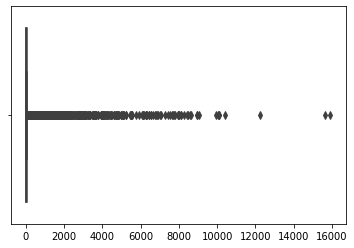

In [25]:
# 문장의 길이를 알아보자
sent_len = [len(sent) for sent in tokenized_texts]

import seaborn as sns
sns.boxplot(sent_len)

pd.Series(sent_len).describe()

In [26]:
print(np.quantile(np.array([len(x) for x in tokenized_texts]), 0.975))

88.0


88개의 문장으로 max_len 설정하면, 상위 2.5퍼센트를 제외하고 커버가능

max_len은 88로 잡고, input_ids와 attention_masks로 구성된 input 만들기

senten_id는 한문장이기에 제외

In [27]:
max_len = 88
bs = 32

In [28]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen = max_len, dtype = 'int', value = tokenizer.convert_tokens_to_ids("[PAD]"),
                          truncating = "post", padding = 'post')

In [29]:
tokenizer.convert_ids_to_tokens(4)

'[MASK]'

In [30]:
label_dict['[PAD]']

29

정답 집합 tags 만들기 

In [31]:
tags = pad_sequences([lab for lab in labels], maxlen = max_len, 
                     value = label_dict['[PAD]'], padding = 'post', dtype = 'int',
                     truncating = 'post')

In [32]:
tags[0]

array([ 2,  0,  0,  0,  0,  1,  1,  2,  3,  3,  3,  4,  4,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29])

In [33]:
int(1 != 0)

1

In [34]:
## PAD는 0 아니면 1로 바꿈
attention_masks = np.array([[int(id != tokenizer.convert_tokens_to_ids("[PAD]")) for id in ii] for ii in input_ids] )

In [35]:
attention_masks

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

Train/Test Split 하기

In [89]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, random_state = 2018, test_size = 0.1)

In [90]:
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

### 개체명 인식 모델 만들기

In [91]:
# TPU 작동을 위한 실행

In [92]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.10.134.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.10.134.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [93]:
SEQ_LEN = max_len

def create_model():
    model = TFBertModel.from_pretrained("monologg/kobert", from_pt = True, num_labels = len(label_dict), output_attentions = False, output_hidden_states = False)
    token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype = tf.int32, name = 'input_word_ids') #토큰 인풋
    mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype = tf.int32, name = 'input_masks') #토큰 인풋

    bert_outputs = model([token_inputs, mask_inputs])
    bert_outputs = bert_outputs[0] # shape : (Batch_size, max_len, 30(개체의 총 갯수))
    nr = tf.keras.layers.Dense(30, activation = 'softmax')(bert_outputs) # shape : (Batch_size, max_len, 30)

    nr_model = tf.keras.Model([token_inputs, mask_inputs], nr)

    nr_model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.00002),
                     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                     metrics = ['sparse_categorical_accuracy'])

    nr_model.summary()

    return nr_model

## 훈련 및 성능 검증

In [94]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

#TPU 활용을 위해 context로 묶기
with strategy.scope():
    nr_model = create_model()
    nr_model.fit([tr_inputs, tr_masks], tr_tags, validation_data = ([val_inputs, val_masks], val_tags), epochs = 3, shuffle = False, batch_size = bs)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 88)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 88)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_4 (TFBertModel)   TFBaseModelOutputWit 92186880    input_word_ids[0][0]             
                                                                 input_masks[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 88, 30)       23070       tf_bert_model_4[0][0]      

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1843/1843 [==============================] - ETA: 0s - loss: 0.4152 - sparse_categorical_accuracy: 0.8965

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


1843/1843 [==============================] - 232s 90ms/step - loss: 0.4151 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.1912 - val_sparse_categorical_accuracy: 0.9486
Epoch 2/3
1843/1843 [==============================] - 127s 69ms/step - loss: 0.1820 - sparse_categorical_accuracy: 0.9516 - val_loss: 0.1754 - val_sparse_categorical_accuracy: 0.9531
Epoch 3/3
1843/1843 [==============================] - 125s 68ms/step - loss: 0.1510 - sparse_categorical_accuracy: 0.9599 - val_loss: 0.1718 - val_sparse_categorical_accuracy: 0.9549


### 성능 확인

In [95]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
y_predicted = nr_model.predict([val_inputs, val_masks])

f_label = [i for i, j in label_dict.items()]
val_tags_l = [index_to_ner[x] for x in np.ravel(val_tags).astype(int).tolist()]
y_predicted_l = [index_to_ner[x] for x in np.ravel(np.argmax(y_predicted, axis=2)).astype(int).tolist()]
f_label.remove("[PAD]")

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


- 각 개체별 f1 score를 측정하도록 하겠습니다.
- 참고로 micro avg는 전체 정답을 기준으로 f1 score을 측정한 것이며,
- macro avg는 각 개체별 f1 score를 가중평균 한 것입니다.

In [96]:
print(classification_report(val_tags_l, y_predicted_l, labels=f_label))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       PER_B       0.88      0.85      0.87     11330
       DAT_B       0.90      0.84      0.87      4239
           -       0.95      0.91      0.93    127187
       ORG_B       0.88      0.81      0.84     11615
       CVL_B       0.79      0.86      0.82     14438
       NUM_B       0.95      0.90      0.93     10409
       LOC_B       0.85      0.80      0.83      5621
       EVT_B       0.79      0.80      0.80      3122
       TRM_B       0.88      0.79      0.83      6993
       TRM_I       0.45      0.43      0.44       681
       EVT_I       0.80      0.76      0.78      1545
       PER_I       0.70      0.73      0.72      1573
       CVL_I       0.48      0.44      0.46       784
       NUM_I       0.64      0.79      0.71      1461
       TIM_B       0.83      0.89      0.86       547
       TIM_I       0.86      0.86      0.86       224
       ORG_I       0.53      0.88      0.66      1326
       DAT_I       0.85    

### 실제 데이터 실습

In [97]:
np.array([tokenizer.encode("아 이제 퇴근하고 싶다", max_length=max_len, pad_to_max_length=True)])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


array([[   2, 3093, 3742, 4760, 5546, 7788, 3072,    3,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1]])

In [98]:
def ner_inference(test_sentence):
    tokenized_sentence = np.array([tokenizer.encode(test_sentence, max_length=max_len, pad_to_max_length=True)])
    tokenized_mask = np.array([[ int(x!=1) for x in tokenized_sentence[0].tolist()]])
    
    ans = nr_model.predict([tokenized_sentence, tokenized_mask])
    ans = np.argmax(ans, axis = 2)

    tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, ans[0]):
  
        if (token.startswith("▁")):
            new_labels.append(index_to_ner[label_idx])
            new_tokens.append(token[1:])
        elif (token=='[CLS]'):
            pass
        elif (token=='[SEP]'):
            pass
        elif (token=='[PAD]'):
            pass
        elif (token != '[CLS]' or token != '[SEP]'):
            new_tokens[-1] = new_tokens[-1] + token

    for token, label in zip(new_tokens, new_labels):
        print("{}\t{}".format(label, token))

In [104]:
test_sentence = "김태규 부산지법 부장판사는 31일 본인 페이스북에 올린 글에서 이같이 주장하며 “관료로 임명되고 정치와 가장 먼 영역에 있는 법원에까지 탄핵의 칼날을 들이대는 것은 이제 이것을 아주 편하게 얼마든지 쓰겠다는 선언에 지나지 않는다”고 비판했다."

In [110]:
ans1[0][0]

array([8.3422856e-05, 2.0603218e-05, 9.9922061e-01, 3.1188894e-05,
       7.4360018e-05, 1.1333326e-04, 1.9949286e-05, 3.0825908e-05,
       4.6752575e-05, 5.7035131e-06, 8.9578607e-06, 7.1025738e-06,
       1.0434255e-05, 4.5592169e-05, 1.3401437e-05, 9.9159015e-06,
       1.0906647e-05, 1.0751217e-05, 2.1262818e-05, 7.9658575e-06,
       2.5078853e-06, 2.2102498e-05, 1.6377247e-05, 6.1855490e-06,
       2.0578746e-05, 1.1428886e-05, 5.1029087e-06, 2.3785615e-06,
       1.7499057e-06, 1.1859759e-04], dtype=float32)

In [106]:
tokenized_sentence = np.array([tokenizer.encode(test_sentence, max_length=max_len, pad_to_max_length=True)])
tokenized_mask = np.array([[int(x!=1) for x in tokenized_sentence[0].tolist()]])

ans1 = nr_model.predict([tokenized_sentence, tokenized_mask])
ans = np.argmax(ans1, axis = 2) ## 30개 중에 가장 높음 확률을 찾음

tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, ans[0]):

    if (token.startswith("▁")):
        new_labels.append(index_to_ner[label_idx])
        new_tokens.append(token[1:])
    elif (token=='[CLS]'):
        pass
    elif (token=='[SEP]'):
        pass
    elif (token=='[PAD]'):
        pass
    elif (token != '[CLS]' or token != '[SEP]'):
        new_tokens[-1] = new_tokens[-1] + token

for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


PER_B	김태규
ORG_B	부산지법
CVL_B	부장판사는
DAT_B	31일
-	본인
-	페이스북에
-	올린
-	글에서
-	이같이
-	주장하며
CVL_B	“관료로
-	임명되고
-	정치와
-	가장
-	먼
-	영역에
-	있는
-	법원에까지
-	탄핵의
-	칼날을
-	들이대는
-	것은
-	이제
-	이것을
-	아주
-	편하게
-	얼마든지
-	쓰겠다는
-	선언에
-	지나지
-	않는다”고
-	비판했다.


In [99]:
ner_inference("송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.")

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


PER_B	송중기
-	시대극은
-	믿고본다.
NUM_B	첫회
-	신선하고
-	좋았다.


In [100]:
ner_inference("""안녕하세요 NLP Engineer로 활동하고 있는 박장원입니다:)

원래 제 전공은 경영학과입니다. 우연한 계기로 자연어 처리를 접하게 되어 현재는 NLP Engineer로 살아가고 있습니다.

한국어 NLP에 더 많은 기여를 하기 위해 오늘도 달립니다!!""")

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


-	안녕하세요
CVL_B	NLP
CVL_I	Engineer로
-	활동하고
-	있는
PER_B	박장원입니다:)
-	원래
-	제
-	전공은
ORG_B	경영학과입니다.
-	우연한
-	계기로
-	자연어
-	처리를
-	접하게
-	되어
-	현재는
CVL_B	NLP
CVL_B	Engineer로
-	살아가고
-	있습니다.
CVL_B	한국어
CVL_B	NLP에
-	더
-	많은
-	기여를
-	하기
-	위해
DAT_B	오늘도
-	달립니다!!


In [101]:
ner_inference("알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라")

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


-	알바쓰고많이만들면되지
-	돈욕심없으면골목식당왜나온겨
-	기[UNK]기게나하고
-	산에가서팔어라


In [102]:
ner_inference("인공지능의 역사는 20세기 초반에서 더 거슬러 올라가보면 이미 17~18세기부터 태동하고 있었지만 이때는 인공지능 그 자체보다는 뇌와 마음의 관계에 관한 철학적인 논쟁 수준에 머무르고 있었다. 그럴 수 밖에 없는 것이 당시에는 인간의 뇌 말고는 정보처리기계가 존재하지 않았기 때문이다. ")

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


TRM_B	인공지능의
-	역사는
DAT_B	20세기
-	초반에서
-	더
-	거슬러
-	올라가보면
-	이미
NUM_B	17~18세기부터
-	태동하고
-	있었지만
-	이때는
-	인공지능
-	그
-	자체보다는
-	뇌와
-	마음의
-	관계에
-	관한
-	철학적인
-	논쟁
-	수준에
-	머무르고
-	있었다.
-	그럴
-	수
-	밖에
-	없는
-	것이
-	당시에는
-	인간의
-	뇌
-	말고는
TRM_B	정보처리기계가
-	존재하지
-	않았기
-	때문이다.
